<a href="https://colab.research.google.com/github/aaronachang/MNIST_Handwritten_Digit_Recognition_CNN/blob/master/MNIST_Handwritten_Digit_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import tqdm

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

%matplotlib inline
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Calculate mean & std
unnormalized_train_set = datasets.MNIST('DATA_MNIST/', train=True, download=True, transform=[transforms.ToTensor()])
mean = unnormalized_train_set.data.float().mean()/255
std = unnormalized_train_set.data.float().std()/255

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean.item(),), (std.item(),))])

train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, pin_memory=True, num_workers=2)

LeNet5 from http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.cnn_layers = nn.Sequential(
            # formula[(in_channel + 2*padding - kernel_size) / stride] + 1
            #1x28x28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1), #6x28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #6x14x14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1), #16x10x10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #16x5x5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0, stride=1), #120x1x1
            nn.ReLU(),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),          
            #nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
class BespokeCNN(nn.Module):
    def __init__(self):
        super(BespokeCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            # formula[(in_channel + 2*padding - kernel_size) / stride] + 1
            #1x28x28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0, stride=1), #16x26x26
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1), #32x24x24
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #32x12x12
            nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=0, stride=1), #64x10x10
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=0, stride=1), #128x8x8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  #256x4x4
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=64),          
            nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Initialize CNN Model

In [ ]:
model = LeNet5()
#model = BespokeCNN()
model.to(device)
print(model)

LeNet5(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Linear(in_features=84, out_features=10, bias=True)
  )
)


Train Model

In [ ]:
epochs = 10 # The total number of iterations

#TODO: verify/vary optimizer parameters?
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def train(mode, dataloader, model, device):
    total_loss = 0
    correct = 0
    total = 0
    for image, label in tqdm.tqdm(dataloader):
        image, label = image.to(device), label.to(device)
        if mode == "train":
            model.train()
        else:
            model.eval()
        
        if mode == "train":
            optimizer.zero_grad(set_to_none=True) # Clear gradients
        output = model(image) # Forward propagation
        loss = criterion(output, label) # Cross entropy loss
        total_loss += loss.item()

        if mode == "train":
            loss.backward() # Calculating gradients
            optimizer.step() # Backpropagation: update parameters            

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += image.shape[0]
    return total_loss/len(testloader), correct/total
    
train_accuracies = []
train_losses = []
valid_accuracies = []
valid_losses = []
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}/{epochs}")
    train_loss, train_accuracy = train("train", trainloader, model, device)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    print(f"Training accuracy: {train_accuracy:.4f}")
    with torch.no_grad():
        valid_loss, valid_accuracy = train("valid", testloader, model, device)
        valid_accuracies.append(valid_accuracy)
        valid_losses.append(valid_loss)
        print(f"Testing accuracy: {valid_accuracy:.4f}")


Epoch: 1/10


100%|██████████| 469/469 [00:19<00:00, 23.84it/s]


Training accuracy: 0.8800


100%|██████████| 79/79 [00:01<00:00, 44.47it/s]


Testing accuracy: 0.9717
Epoch: 2/10


100%|██████████| 469/469 [00:10<00:00, 44.61it/s]


Training accuracy: 0.9768


100%|██████████| 79/79 [00:01<00:00, 44.27it/s]


Testing accuracy: 0.9832
Epoch: 3/10


100%|██████████| 469/469 [00:11<00:00, 40.71it/s]


Training accuracy: 0.9836


100%|██████████| 79/79 [00:01<00:00, 46.41it/s]


Testing accuracy: 0.9839
Epoch: 4/10


100%|██████████| 469/469 [00:10<00:00, 45.58it/s]


Training accuracy: 0.9871


100%|██████████| 79/79 [00:01<00:00, 44.66it/s]


Testing accuracy: 0.9873
Epoch: 5/10


100%|██████████| 469/469 [00:10<00:00, 44.50it/s]


Training accuracy: 0.9893


100%|██████████| 79/79 [00:01<00:00, 44.80it/s]


Testing accuracy: 0.9884
Epoch: 6/10


100%|██████████| 469/469 [00:10<00:00, 44.31it/s]


Training accuracy: 0.9907


100%|██████████| 79/79 [00:01<00:00, 45.17it/s]


Testing accuracy: 0.9892
Epoch: 7/10


100%|██████████| 469/469 [00:10<00:00, 44.57it/s]


Training accuracy: 0.9926


100%|██████████| 79/79 [00:01<00:00, 44.64it/s]


Testing accuracy: 0.9894
Epoch: 8/10


100%|██████████| 469/469 [00:10<00:00, 44.23it/s]


Training accuracy: 0.9929


100%|██████████| 79/79 [00:02<00:00, 38.70it/s]


Testing accuracy: 0.9907
Epoch: 9/10


100%|██████████| 469/469 [00:11<00:00, 40.85it/s]


Training accuracy: 0.9945


100%|██████████| 79/79 [00:01<00:00, 43.75it/s]


Testing accuracy: 0.9890
Epoch: 10/10


100%|██████████| 469/469 [00:10<00:00, 43.78it/s]


Training accuracy: 0.9948


100%|██████████| 79/79 [00:01<00:00, 44.02it/s]

Testing accuracy: 0.9905


Plot Data

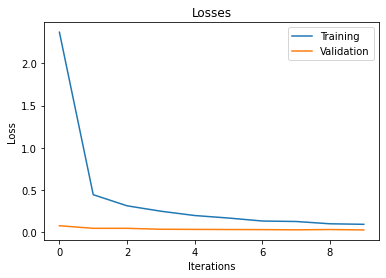

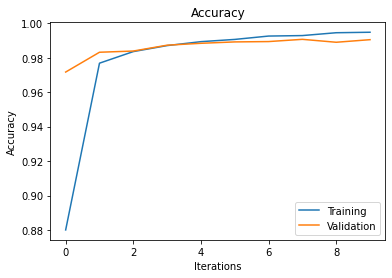

In [ ]:
plt.title("Losses")
plt.plot(train_losses, label='Training')
plt.plot(valid_losses, label='Validation')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Accuracy")
plt.plot(train_accuracies, label='Training')
plt.plot(valid_accuracies, label='Validation')
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Prediction Example (delete later)

torch.Size([1, 1, 28, 28])
[2.7403939e-08 3.0084596e-08 4.0829215e-10 9.0798331e-08 8.6855367e-03
 2.0803887e-08 1.1205823e-09 8.2536673e-05 9.3244553e-06 9.9122250e-01]


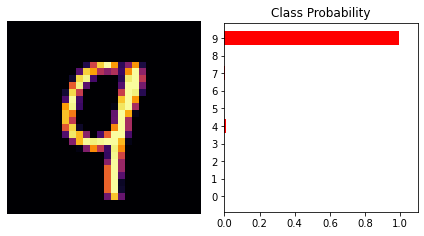

In [ ]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)

img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()